In [2]:
from __future__ import absolute_import, division, print_function
from matplotlib.font_manager import _rebuild; _rebuild()
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as spio
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from scipy import interp
from mpl_toolkits.mplot3d import Axes3D

tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


In [17]:
"""Set all global parameters to be monitored"""

n_splits_o = 2
n_splits_i = 3
factor_red = 1

# To reduce the computational expense and the number of features to try in PCA during Hyperparameter optimization
nb_feats_min = 70
nb_feats_max = 110

In [18]:
"""Set sthe animal ID"""

animal_name = 'sKH03'

In [19]:
"""Load the dataset and set randomness."""
# (from Emma's code)

# Initialize random number generator for reproducibility.
seed = 7
np.random.seed(seed)

# import file into a dictionary
data = spio.loadmat('D:\\Project with Senan\\Stim data 190310\\labeleddat\\with 16 channels\\SPES only - all seizures\\features_sKH03_2019-05-29.mat')


# get the fields
features = data['features'][()]
labels = data['labels'][()]

print(features.shape)
print(labels.shape)

(63382, 176)
(63382, 1)


In [20]:
"""Reduce the number of classes: delete the seizures - Prediction model"""

a = np.where(labels == 2)

labels_tmp = np.delete(labels, a)
features_tmp = np.delete(features, a, 0);
animal_labels = labels_tmp
animal_features = features_tmp

print(animal_labels.shape)
print(animal_features.shape)

(63239,)
(63239, 176)


In [21]:
"""Reducing the size of the vectors for easier computation"""
factor = factor_red

"""Shuffling the data to train/test on smaller subsets"""
shuffled_animal_features = np.empty(animal_features.shape, dtype=animal_features.dtype)
shuffled_animal_labels = np.empty(animal_labels.shape, dtype=animal_labels.dtype)
permutation = np.random.permutation(len(animal_labels))
for old_index, new_index in enumerate(permutation):
        shuffled_animal_features [new_index] = animal_features[old_index]
        shuffled_animal_labels[new_index] = animal_labels[old_index]
animal_features = shuffled_animal_features
animal_labels = shuffled_animal_labels

animal_features = animal_features[0:int(len(animal_features)/factor),:]
animal_labels = animal_labels[0:np.int(len(animal_labels)/factor)]

In [22]:
print(animal_labels.shape)
print(animal_features.shape)

(63239,)
(63239, 176)


# Separability with no classifier

In [23]:
"""Split data into training and testing for cross-validation."""

data = animal_features
labels = animal_labels


data_train, data_test, labels_train, labels_test = train_test_split(data, labels);

explained variance ratio (first three components): [0.36941625 0.18928135 0.11505805 0.06166237 0.02395557 0.02142195
 0.01706614 0.01624831 0.0143892  0.01209741 0.00966887 0.00844047
 0.00790296 0.00736706 0.00674029 0.00595398 0.00563903 0.00506591
 0.00473608 0.00435034 0.00396477 0.00360948 0.00342041 0.00334825
 0.0032375  0.00317121 0.00304823 0.0028137  0.0027929  0.00267156
 0.00263713 0.00258643 0.00237996 0.00227958 0.00223135 0.00211415
 0.00207073 0.00200491 0.00187974 0.00183039 0.00177723 0.00165069
 0.00161726 0.00159561 0.00150451 0.00148623 0.00143865 0.00138547
 0.00129021 0.00119857 0.00113867 0.00110482 0.00102642 0.00097842
 0.00091996 0.00090781 0.00087226 0.00085388 0.00080351 0.00078047
 0.00074297 0.00071727 0.00070069 0.00067201 0.00064879 0.00061999
 0.00059889 0.00056817 0.0005467  0.00052513]


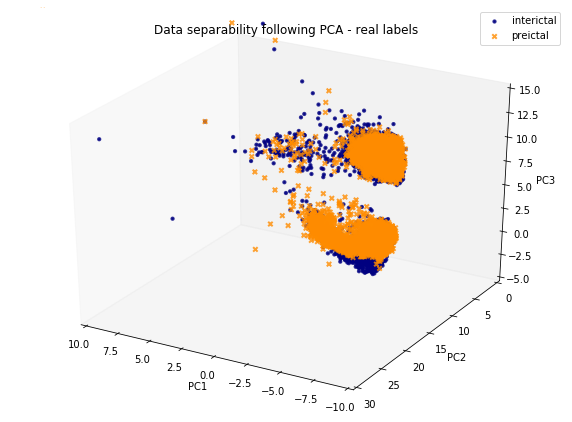

In [28]:
scaler = preprocessing.StandardScaler().fit(data_train)
data_train_zscored = scaler.transform(data_train) 
data_test_zscored = scaler.transform(data_test) 

pca = PCA(n_components=70)
data_train_transf = pca.fit(data_train_zscored).transform(data_train_zscored)
data_test_transf = pca.fit(data_test_zscored).transform(data_test_zscored)


# Percentage of variance explained for each component
print('explained variance ratio (first three components): %s'
      % str(pca.explained_variance_ratio_))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['navy', 'darkorange']
markers = ['.', 'x']
target_names = ['interictal', 'preictal']
lw = 2

for color, marker, i, target_name in zip(colors, markers, [0, 1], target_names):
    ax.scatter(data_test_transf[labels_test == i, 0], data_test_transf[labels_test == i, 1], data_test_transf[labels_test == i, 2], color=color, marker=marker, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Data separability following PCA - real labels')
ax.view_init(30, 120)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.set_xlim(-10,10)
ax.set_ylim(0,30)
ax.set_zlim(-5,15)

ax.grid(False)
fig.set_size_inches(10, 7.5)
plt.savefig('separability_' + animal_name + '_noClassifier.png')  

plt.show()

# Separability with classifier

In [25]:
scaler = preprocessing.StandardScaler().fit(data_train)
data_train_zscored = scaler.transform(data_train) 
data_test_zscored = scaler.transform(data_test) 

pca = PCA(n_components=110)
data_train_transf = pca.fit(data_train_zscored).transform(data_train_zscored)
data_test_transf = pca.fit(data_test_zscored).transform(data_test_zscored)


# Percentage of variance explained for each component
print('explained variance ratio (first three components): %s'
      % str(pca.explained_variance_ratio_))


clf = svm.SVC(kernel='rbf', gamma='scale', probability=True)
    
y_score = clf.fit(data_train_transf, labels_train)
    
y_predict = clf.predict_proba(data_test_transf)
y_predict_train = clf.predict(data_train_transf)


explained variance ratio (first three components): [3.69416247e-01 1.89281347e-01 1.15058050e-01 6.16623653e-02
 2.39555743e-02 2.14219468e-02 1.70661441e-02 1.62483143e-02
 1.43892015e-02 1.20974082e-02 9.66887455e-03 8.44047434e-03
 7.90295988e-03 7.36706199e-03 6.74029293e-03 5.95398262e-03
 5.63902827e-03 5.06590950e-03 4.73607750e-03 4.35034187e-03
 3.96477307e-03 3.60948070e-03 3.42041143e-03 3.34825042e-03
 3.23750403e-03 3.17121353e-03 3.04822753e-03 2.81370422e-03
 2.79290455e-03 2.67156260e-03 2.63712675e-03 2.58643501e-03
 2.37996475e-03 2.27957634e-03 2.23134801e-03 2.11414579e-03
 2.07073119e-03 2.00491421e-03 1.87973670e-03 1.83039441e-03
 1.77723443e-03 1.65069465e-03 1.61726162e-03 1.59560602e-03
 1.50451078e-03 1.48622891e-03 1.43864701e-03 1.38546766e-03
 1.29021075e-03 1.19857549e-03 1.13867240e-03 1.10483150e-03
 1.02645061e-03 9.78442691e-04 9.20048777e-04 9.07832591e-04
 8.72283719e-04 8.53899749e-04 8.03624918e-04 7.80654088e-04
 7.43273337e-04 7.17398631e-04 7.0

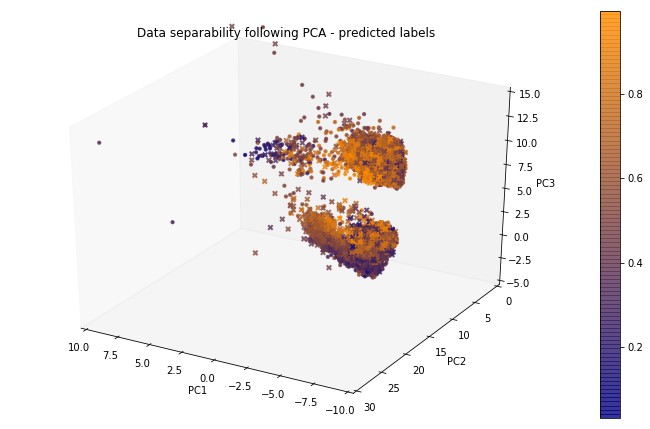

In [26]:

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['navy', 'darkorange']
cmap = LinearSegmentedColormap.from_list('my_List', colors, N=100)
markers = ['.', 'x']
target_names = ['interictal', 'preictal']
lw = 2


for color, marker, i, target_name in zip(colors, markers, [0, 1], target_names):
    t = y_predict[labels_test == i, 1]
    ax.scatter(data_test_transf[labels_test == i, 0], data_test_transf[labels_test == i, 1], data_test_transf[labels_test == i, 2], c=t, cmap=cmap, marker=marker, alpha=.8, lw=lw,
                label=target_name)
plt.title('Data separability following PCA - predicted labels')
ax.view_init(30, 120)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.set_xlim(-10,10)
ax.set_ylim(0,30)
ax.set_zlim(-5,15)

ax.grid(False)
fig.set_size_inches(12.5, 7.5)
ax=plt.gca() #get the current axes
PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
plt.colorbar(PCM, ax=ax) 
plt.savefig('separability_' + animal_name + '_withClassifier.png') 

plt.show()

In [1]:
np.mean(data_test_transf[:,0])

NameError: name 'np' is not defined

In [29]:
print(t)

[0.63884687 0.23908803 0.46190395 ... 0.21676245 0.84501319 0.61216739]


In [30]:
t.shape

(7489,)

In [31]:
labels_test.shape

(15810,)